# Using DQN and Double DQN in Pearl with different neural network instantiations.

Here is a [better rendering](https://nbviewer.org/github/facebookresearch/Pearl/blob/main/tutorials/sequential_decision_making/DQN_and_DoubleDQN_example.ipynb) of this notebook on [nbviewer](https://nbviewer.org/).

- The purpose of this tutorial is twofold. First, it illustrates how users can use implementations of value based methods, for example, DQN and Double DQN, in Pearl. We use a simple Gym environment for illustration.

- Second, it illustrates how users can instantiate a neural network (outside of a Pearl Agent) and pass it to different policy learners in Pearl. For both examples (DQN and Double DQN), we use an instantiation of `QValueNetworks` outside of the Pearl Agent. The default way right now is to instantiate a Q-value network inside the agent's policy learner.

- Users can also instantiate custom networks and use these with different policy learners in Pearl, but are expected to follow the general design of the value networks/critic networks/actor networks base class. For example, for value based methods such as DQN and Double DQN, users should follow the design of the `QValueNetwork` base class.

In [1]:
%load_ext autoreload
%autoreload 2

# Pearl Installation

If you haven't installed Pearl, please make sure you install Pearl with the following cell. Otherwise, you can skip the cell below.



In [2]:
# Pearl installation from github. This install also includes PyTorch, Gym and Matplotlib

%pip uninstall Pearl -y
%rm -rf Pearl
!git clone https://github.com/facebookresearch/Pearl.git

Cloning into 'Pearl'...
remote: Enumerating objects: 6139, done.
remote: Counting objects: 100% (2348/2348), done.
remote: Compressing objects: 100% (724/724), done.
remote: Total 6139 (delta 1796), reused 2070 (delta 1606), pack-reused 3791 (from 1)
Receiving objects: 100% (6139/6139), 54.48 MiB | 9.96 MiB/s, done.
Resolving deltas: 100% (4123/4123), done.


In [3]:
%cd Pearl
%pip install .
%cd ..

/content/Pearl
Processing /content/Pearl
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadat

In [4]:
!pip install swig

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 59.5 MB/s eta 0:00:00


In [5]:
!pip install gymnasium[box2d]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 27.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2376098 sha256=ad5941ced54f0da6838a102a8d687c2d524f5606d91b8a4ee637eb667bef3af6
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py


# Import Modules

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from pearl.neural_networks.sequential_decision_making.q_value_networks import VanillaQValueNetwork
from pearl.utils.functional_utils.experimentation.set_seed import set_seed
from pearl.action_representation_modules.identity_action_representation_module import IdentityActionRepresentationModule
from pearl.policy_learners.sequential_decision_making.deep_q_learning import DeepQLearning
from pearl.policy_learners.sequential_decision_making.double_dqn import DoubleDQN
from pearl.neural_networks.sequential_decision_making.actor_networks import VanillaContinuousActorNetwork
from pearl.policy_learners.sequential_decision_making.ppo import ProximalPolicyOptimization
from pearl.replay_buffers.sequential_decision_making.fifo_off_policy_replay_buffer import FIFOOffPolicyReplayBuffer
from pearl.policy_learners.exploration_modules.common.epsilon_greedy_exploration import EGreedyExploration
from pearl.replay_buffers.sequential_decision_making.fifo_on_policy_replay_buffer import FIFOOnPolicyReplayBuffer
from pearl.replay_buffers.sequential_decision_making.on_policy_replay_buffer import OnPolicyReplayBuffer
from pearl.utils.functional_utils.train_and_eval.online_learning import online_learning
from pearl.policy_learners.exploration_modules.common.normal_distribution_exploration import NormalDistributionExploration
from pearl.pearl_agent import PearlAgent
from pearl.utils.instantiations.environments.gym_environment import GymEnvironment
from pearl.utils.instantiations.spaces.discrete import DiscreteSpace
from pearl.action_representation_modules.one_hot_action_representation_module import (
    OneHotActionTensorRepresentationModule,
)

set_seed(0)

# CarPole-v1

In [ ]:
env_str = "CartPole-v1"
env = GymEnvironment(env_str)
print(f"Gym Environment: {env_str}")
print(f"Observation Space: {env.observation_space.shape[0]}")
print(f"Number of Actions: {env.action_space.n}")
print(f"Action Space Dimensions: {env.action_space.action_dim}")
print(f"Is Action Space Continuous: {env.action_space.is_continuous}")
env.close()

Gym Environment: CartPole-v1
Observation Space: 4
Number of Actions: 2
Action Space Dimensions: 1
Is Action Space Continuous: False


## Double DQN


In [ ]:
# Create Environment
env = GymEnvironment(env_str)

# VanillaQValueNetwork class uses a simple mlp for approximating the Q values.
#  - Input dimension of the mlp = (state_dim + action_dim)
#  - Size of the intermediate layers are specified as list of `hidden_dims`.
hidden_dims = [64, 64]

# We will be using a one hot representation for representing actions. So take action_dim = num_actions.
Q_value_network = VanillaQValueNetwork(state_dim=env.observation_space.shape[0],  # dimension of the state representation
                                       action_dim=env.action_space.n,             # dimension of the action representation
                                       hidden_dims=hidden_dims,                   # dimensions of the intermediate layers
                                       output_dim=1)                              # set to 1 (Q values are scalars)

# Instead of using the 'network_type' argument, use the 'network_instance' argument.
# Pass Q_value_network as the `network_instance` to the `DoubleDQN` policy learner.
DoubleDQNagent = PearlAgent(
    policy_learner=DoubleDQN(
        state_dim=env.observation_space.shape[0],
        action_space=env.action_space,
        batch_size=64,
        training_rounds=10,
        soft_update_tau=0.75,
        network_instance=Q_value_network,   # pass an instance of Q value network to the policy learner.
        action_representation_module=OneHotActionTensorRepresentationModule(
            max_number_actions=env.action_space.n
        ),
    ),
    replay_buffer=FIFOOffPolicyReplayBuffer(10_000),
)

# The online learning function in Pearl implements environment interaction and learning
# and returns a dictionary with episodic returns
info_DoubleDQN = online_learning(
    agent=DoubleDQNagent,
    env=env,
    number_of_episodes=200,
    print_every_x_episodes=20,   # print returns after every 10 episdoes
    learn_after_episode=True,    # instead of updating after every environment interaction, Q networks are updates at the end of each episode
    seed=0
)

env.close()

In [ ]:
# info["return"] refers to the episodic returns
torch.save(info_DoubleDQN["return"], "DoubleDQN-return.pt")
plt.plot(np.arange(len(info_DoubleDQN["return"])),
         info_DoubleDQN["return"],
         label="DoubleDQN")

plt.title("Episodic returns")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.legend()
plt.show()

## Proximal Policy Optimization (PPO)

In [ ]:
# Create Environment
env = GymEnvironment(env_str)

# Create Pearl Agent
PPOagent = PearlAgent(
    policy_learner=ProximalPolicyOptimization(
        state_dim=env.observation_space.shape[0],
        use_critic=True,
        action_space=env.action_space,
        actor_hidden_dims=[64, 64],
        critic_hidden_dims=[64, 64],
        batch_size=64,
        training_rounds=10,
        critic_learning_rate=1e-3,
        actor_learning_rate=1e-3,
        action_representation_module=OneHotActionTensorRepresentationModule(
            max_number_actions=env.action_space.n,
        ),
    ),
    replay_buffer=OnPolicyReplayBuffer(250_000),
)

info_PPO = online_learning(
    agent=PPOagent,
    env=env,
    number_of_episodes=750,
    print_every_x_episodes=50,
    learn_after_episode=True,
    seed=0
)

env.close()

In [ ]:
# info["return"] refers to the episodic returns
torch.save(info_PPO["return"], "info_PPO-return.pt")
plt.plot(np.arange(len(info_PPO["return"])),
         info_PPO["return"],
         label="PPO")

plt.title("Episodic returns")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.legend()
plt.show()

# LunarLander-v2

In [7]:
env_str = "LunarLander-v2"
env = GymEnvironment(env_str)
print(f"Gym Environment: {env_str}")
print(f"Observation Space: {env.observation_space.shape[0]}")
print(f"Number of Actions: {env.action_space.n}")
print(f"Action Space Dimensions: {env.action_space.action_dim}")
print(f"Is Action Space Continuous: {env.action_space.is_continuous}")
env.close()

Gym Environment: LunarLander-v2
Observation Space: 8
Number of Actions: 4
Action Space Dimensions: 1
Is Action Space Continuous: False


## Double DQN

In [ ]:
# Create Environment
env = GymEnvironment(env_str)

# VanillaQValueNetwork class uses a simple mlp for approximating the Q values.
#  - Input dimension of the mlp = (state_dim + action_dim)
#  - Size of the intermediate layers are specified as list of `hidden_dims`.
hidden_dims = [64, 64]


# We will be using a one hot representation for representing actions. So take action_dim = num_actions.
Q_value_network = VanillaQValueNetwork(state_dim=env.observation_space.shape[0],  # dimension of the state representation
                                       action_dim=env.action_space.n,             # dimension of the action representation
                                       hidden_dims=hidden_dims,                   # dimensions of the intermediate layers
                                       output_dim=1)                              # set to 1 (Q values are scalars)

# Create Pearl Agent
# Instead of using the 'network_type' argument, use the 'network_instance' argument.
# Pass Q_value_network as the `network_instance` to the `DeepQLearning` policy learner.
DoubleDQNagent = PearlAgent(
    policy_learner=DoubleDQN(
        state_dim=env.observation_space.shape[0],
        action_space=env.action_space,
        batch_size=64,
        network_instance=Q_value_network,   # pass an instance of Q value network to the policy learner.
        exploration_module=EGreedyExploration(0.025),
        action_representation_module=OneHotActionTensorRepresentationModule(
            max_number_actions=env.action_space.n
        ),
    ),
    replay_buffer=FIFOOffPolicyReplayBuffer(1_000_000),
)

info_DoubleDQN = online_learning(
    agent=DoubleDQNagent,
    env=env,
    number_of_episodes=3000,
    print_every_x_episodes=50,   # print returns after every 50 episdoes
    learn_after_episode=True,    # instead of updating after every environment interaction, Q networks are updates at the end of each episode
    record_period=50,
    seed=0
)

env.close()

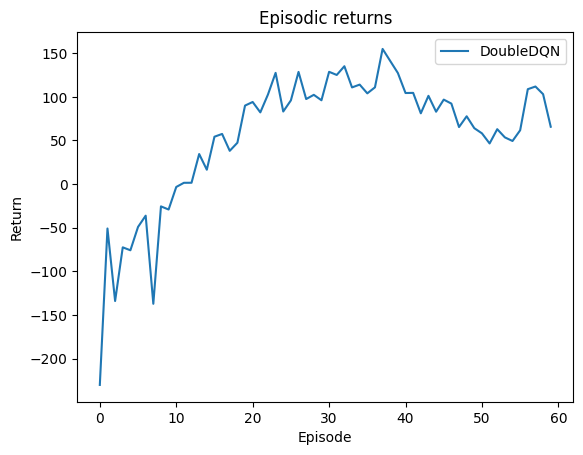

In [ ]:
# info["return"] refers to the episodic returns
torch.save(info_DoubleDQN["return"], "DoubleDQN-return.pt")
plt.plot(np.arange(len(info_DoubleDQN["return"])),
         info_DoubleDQN["return"],
         label="DoubleDQN")

plt.title("Episodic returns")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.legend()
plt.show()

## Proximal Policy Optimization (PPO)

In [ ]:
# Create Environment
env = GymEnvironment(env_str)

# Create Pearl Agent
PPOagent = PearlAgent(
    policy_learner=ProximalPolicyOptimization(
        state_dim=env.observation_space.shape[0],
        use_critic=True,
        action_space=env.action_space,
        actor_hidden_dims=[64, 64],
        critic_hidden_dims=[64, 64],
        critic_learning_rate=3e-4,
        actor_learning_rate=3e-4,
        epsilon=0.2,
        batch_size=128,
        training_rounds=100,
        entropy_bonus_scaling=0.01,
        action_representation_module=OneHotActionTensorRepresentationModule(
            max_number_actions=env.action_space.n,
        ),
    ),
    replay_buffer=OnPolicyReplayBuffer(250_000),
)

info_PPO = online_learning(
    agent=PPOagent,
    env=env,
    #number_of_episodes=1000,
    number_of_steps=2_000_000,
    print_every_x_episodes=100,
    #print_every_x_steps=2048,
    learn_every_k_steps=2048,
    record_period=2048,
    learn_after_episode=False,
    seed=0
)

env.close()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


episode 100, step 9677, agent=PearlAgent with ProximalPolicyOptimization, OnPolicyReplayBuffer, env=LunarLander-v2
return: -185.9570230199024
episode 200, step 23844, agent=PearlAgent with ProximalPolicyOptimization, OnPolicyReplayBuffer, env=LunarLander-v2
return: -13.244733727537096
episode 300, step 53947, agent=PearlAgent with ProximalPolicyOptimization, OnPolicyReplayBuffer, env=LunarLander-v2
return: -133.35200564889237
episode 400, step 134789, agent=PearlAgent with ProximalPolicyOptimization, OnPolicyReplayBuffer, env=LunarLander-v2
return: 69.07016391676734
episode 500, step 218432, agent=PearlAgent with ProximalPolicyOptimization, OnPolicyReplayBuffer, env=LunarLander-v2
return: 159.8795195334179
episode 600, step 280898, agent=PearlAgent with ProximalPolicyOptimization, OnPolicyReplayBuffer, env=LunarLander-v2
return: 184.56189489871483
episode 700, step 350217, agent=PearlAgent with ProximalPolicyOptimization, OnPolicyReplayBuffer, env=LunarLander-v2
return: 167.84619050768

In [ ]:
# info["return"] refers to the episodic returns
torch.save(info_PPO["return"], "info_PPO-return.pt")
plt.plot(np.arange(len(info_PPO["return"])),
         info_PPO["return"],
         label="PPO")

plt.title("Episodic returns")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.legend()
plt.show()